In [122]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345678',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/pc/Downloads/E-Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db=mysql.connector.connect(host="localhost",
                          username="root",
                           password="12345678",
                          database= "ecommerce")

cur= db.cursor()


 # List all unique cities where customers are located.

In [138]:
query="""SELECT DISTINCT customer_city FROM customers; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [139]:
query="""SELECT COUNT(order_id) 
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2017; """

cur.execute(query)

data=cur.fetchall()

"total order placed in 2017 are",data[0][0]

('total order placed in 2017 are', 315707)

 # Find the total sales per category.

In [140]:
query="""SELECT products.product_category AS category, 
ROUND(SUM(payments.payment_value), 2) AS sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category; """

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data,columns= ["category","sales"])
df

,category,sales
0,perfumery,4.053909e+07
1,Furniture Decoration,1.144141e+08
2,telephony,3.895056e+07
3,bed table bath,1.370043e+08
4,automotive,6.818355e+07
...,...,...
69,cds music dvds,9.595440e+04
70,La Cuisine,2.330824e+05
71,Fashion Children's Clothing,6.285360e+04
72,PC Gamer,1.739544e+05


# Calculate the percentage of orders that were paid in installments.

In [141]:
query="""SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS percentage
FROM payments; """

cur.execute(query)

data=cur.fetchall()

"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

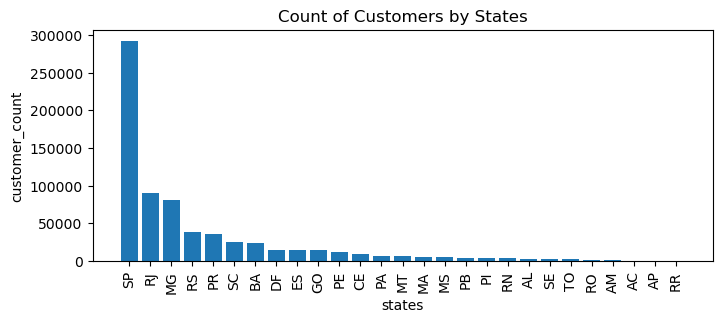

In [142]:
query="""SELECT customer_state, COUNT(customer_id) AS customer_count
FROM customers 
GROUP BY customer_state; """

cur.execute(query)
data=cur.fetchall()

df= pd.DataFrame(data ,columns=["state", "customer_count"])
df= df.sort_values(by= "customer_count", ascending=False)

plt.figure(figsize= (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

<function matplotlib.pyplot.show(close=None, block=None)>

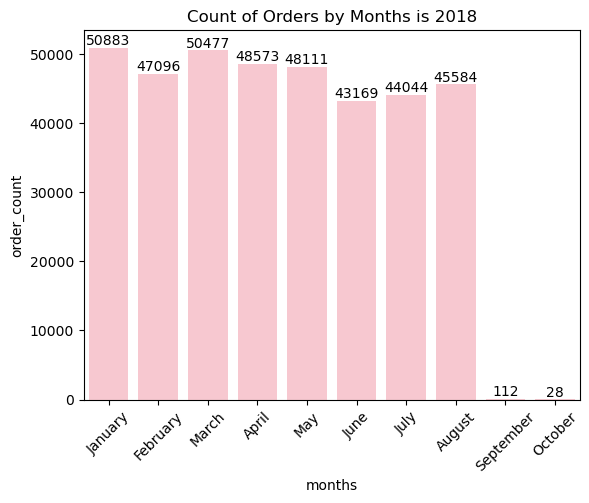

In [143]:
query="""SELECT MONTHNAME(order_purchase_timestamp) AS months, COUNT(order_id) AS order_count
FROM orders 
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months; """

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=["months","order_count"])

o= ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax=sns.barplot(x=df["months"], y=df["order_count"],data=df, order =o,color="pink")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show

# Find the average number of products per order, grouped by customer city.

In [144]:
query = """WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers 
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city 
ORDER BY average_orders DESC; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,196.00
1,celso ramos,182.00
2,datas,168.00
3,candido godoi,168.00
4,matias olimpio,140.00
5,cidelandia,112.00
6,curralinho,112.00
7,picarra,112.00
8,morro de sao paulo,112.00
9,teixeira soares,112.00


# Calculate the percentage of total revenue contributed by each product category.

In [145]:
query = """SELECT UPPER(products.product_category) AS category, 
ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS sales_percentage
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category 
ORDER BY sales_percentage DESC; """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head(10)

,Category,percentage distribution
0,BED TABLE BATH,213.95
1,HEALTH BEAUTY,207.06
2,COMPUTER ACCESSORIES,198.06
3,FURNITURE DECORATION,178.67
4,WATCHES PRESENT,178.55
5,SPORT LEISURE,173.92
6,HOUSEWARES,136.77
7,AUTOMOTIVE,106.48
8,GARDEN TOOLS,104.73
9,COOL STUFF,97.41



# Identify the correlation between product price and the number of times a product has been purchased.

In [146]:
cur = db.cursor()
query = """SELECT products.product_category, 
COUNT(order_items.product_id) AS order_count,
ROUND(AVG(order_items.price), 2) AS price
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1= df["order_count"]
arr2= df["price"]

a=np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157564


# Calculate the total revenue generated by each seller, and rank them by revenue.

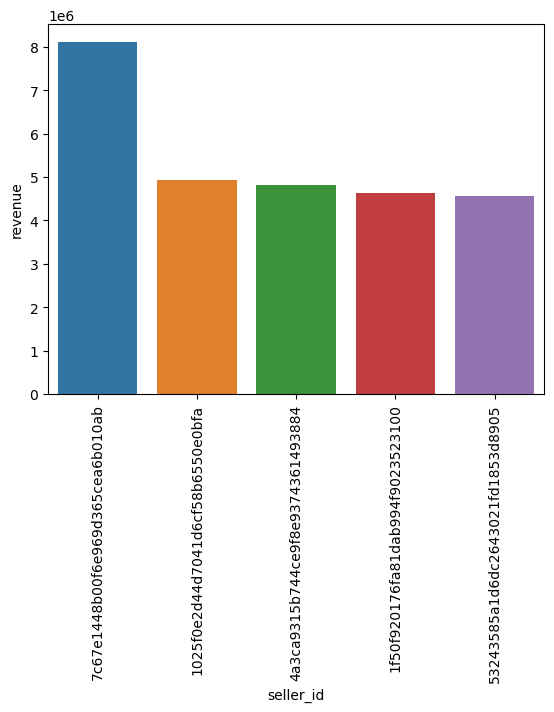

In [147]:
query = """ SELECT *, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn 
FROM (
    SELECT order_items.seller_id, SUM(payments.payment_value) AS revenue
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()

sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [148]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp 
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM (
    SELECT orders.customer_id, orders.order_purchase_timestamp, 
    payments.payment_value AS payment
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2908803,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908804,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908805,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908806,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [149]:
query = """SELECT years, months, payment, SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales 
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months 
    ORDER BY years, months
) AS a; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,7062.72,7.062720e+03
1,2016,10,1654533.44,1.661596e+06
2,2016,12,549.36,1.662146e+06
3,2017,1,3877665.12,5.539811e+06
4,2017,2,8173424.27,1.371323e+07
5,2017,3,12596180.79,2.630942e+07
6,2017,4,11698064.83,3.800748e+07
7,2017,5,16601726.96,5.460921e+07
8,2017,6,14315738.65,6.892495e+07
9,2017,7,16586721.75,8.551167e+07


# Calculate the year-over-year growth rate of total sales.

In [150]:
query = """WITH a AS (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years 
    ORDER BY years
)
SELECT years, ((payment - LAG(payment, 1) OVER (ORDER BY years)) / LAG(payment, 1) OVER (ORDER BY years)) * 100 AS yoy_growth
FROM a; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [151]:
query = """WITH a AS (
    SELECT customers.customer_id, MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
    AND orders.order_purchase_timestamp > first_order
    AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS retention_rate
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id; """

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

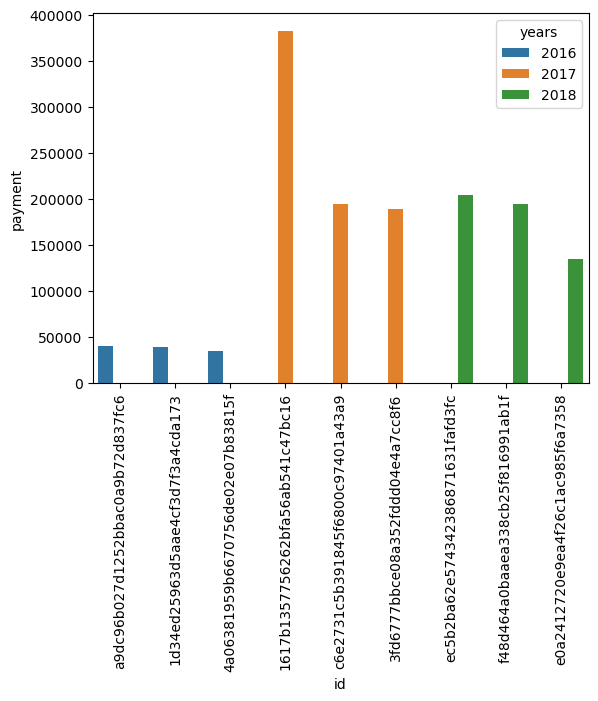

In [152]:
query = """SELECT years, customer_id, payment, d_rank
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
    orders.customer_id,
    SUM(payments.payment_value) AS payment,
    DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp) 
    ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE d_rank <= 3; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years","id","payment","rank"])

sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()